# Regression

## Importing the libraries

In [241]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objs as go
import seaborn as sns


import cv2
import csv
from bs4 import BeautifulSoup


from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from skimage.feature import local_binary_pattern

from lazypredict.Supervised import LazyRegressor, LazyClassifier
from category_encoders import TargetEncoder,  CountEncoder

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textblob import TextBlob
import re

from datetime import datetime
from tqdm import tqdm
from scipy import stats

import requests
import os
import shutil

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textblob import TextBlob
import re

from datetime import datetime
from tqdm import tqdm
from scipy import stats

import requests
import os
import shutil

import warnings

# Download nltk packages if not already downloaded
# nltk.download()

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

stop_words = set(stopwords.words('english'))

warnings.filterwarnings('ignore')

## Load the dataset

In [242]:
df_origin = pd.read_csv('datasets/train/games-regression-dataset.csv')

## Data Gathering

### Download the icons

In [243]:
# Download the images
def download_image(url, filename):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)


def download_icons(_df):
    # Convert to string
    _df['Icon URL'] = _df['Icon URL'].astype(str)

    # Create a folder to store the images
    if not os.path.exists('icons/train'):
        os.makedirs('icons/train')

    # Download the images if they don't exist
    for i, row in tqdm(_df.iterrows(), total=_df.shape[0]):
        if not os.path.exists('icons/train/' + str(i) + '.png'):
            download_image(row['Icon URL'], 'icons/train/' + str(i) + '.png')

    # Replace the URL with the icon filename which is the index of the row
    _df['Icon URL'] = _df.apply(lambda row : f'icons/train/{row.name}.png', axis=1)
    
    return _df


### Download the reviews

In [244]:
def web_scrapping(_df):
    data = pd.DataFrame(columns=["ID", "Reviews"])
    
    for url, id_value in zip(_df['URL'], _df['ID']):
        # Redirect to the reviews page
        url += "?see-all=reviews"
        response = requests.get(url)
        
        # Check if request was successful
        if response.status_code == 200:  
            soup = BeautifulSoup(response.text, 'html.parser')
            blocks = soup.findAll("blockquote")
            review_list = []
            for blockquote in blocks:
                review = blockquote.find('p').text
                review_list.append(review)
                
            if len(review_list) != 0:
                new_row = {'ID': id_value, "Reviews": review_list}
                data = data.append(new_row, ignore_index=True)
    
    data.to_csv('datasets/train/reviews.csv', index=False)

In [245]:
def reviews_splitting(data):

    for i in range (len(data)):
        data.at[i, 'Reviews'] = data.at[i, "Reviews"].split("',")
        data.at[i,"ID"] =data.at[i,"ID"]
        
    data = data.explode('Reviews')
    return data

In [246]:
def reviews_cleaning(data):
  # Convert text to lowercase
  data['Reviews'] = data['Reviews'].apply(lambda x: str(x).lower())

  # Replace newline characters with an empty string
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\\n', ' ', x))

  # Remove black squares
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\\u25a0', '', x))

  # Remove special characters and punctuations
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'[^\w\s]+', '', x))

  # Remove numbers
  data['Reviews'] = data['Reviews'].apply(lambda x: " ".join([word for word in x.split() if not any(char.isdigit() for char in word)]))

  # Remove extra whitespaces
  data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\s+', ' ', x))

  # Remove stop words
  data['Reviews'] = data['Reviews'].apply(lambda x: " ".join([word for word in x.lower().split() if word not in stop_words]))

  # Remove empty strings
  data = data[data['Reviews'].apply(lambda x: len(x)>0)]
  
  # Group by ID
  data = data.groupby('ID')['Reviews'].apply(list).reset_index()
  
  return data

In [247]:
def download_reviews(_df):

    # Web scrapping to get the html of the reviews, Only run once
    # web_scrapping(_df)

    df_reviews = pd.read_csv('datasets/train/reviews.csv')

    df_reviews = reviews_splitting(df_reviews)

    df_reviews = reviews_cleaning(df_reviews)

    # Merge The Sentiment with the original dataset
    _df = _df.merge(df_reviews, on='ID', how='left')

    return _df

## Data Exploration

### General information

In [248]:
# df.head()

In [249]:
# df.info()

In [250]:
# df.isnull().sum()

### Genres

In [251]:
def genres_analysis(_df):
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

    genre_counts = _df.explode('Genres').groupby('Genres').size().sort_values(ascending=False)
    print(genre_counts)


### Developer

In [252]:
def dev_analysis(_df):

    print(_df['Developer'].value_counts())
    
    # print the number developers with more than 1 game
    print(len(_df['Developer'].value_counts()[_df['Developer'].value_counts() > 1]))

    print(_df['Developer'].unique().size)

### Dates

In [253]:
def date_analysis(_df):
    # Plot the distribution of the date columns

    fig, ax = plt.subplots(5, 2, figsize=(20, 20))

    # df = date_preprocessing(df)

    # game_age distribution
    sns.histplot(_df['game_age'], ax=ax[0, 0])
    sns.boxplot(_df['game_age'], ax=ax[0, 1], orient='h')

    # last_update distribution
    sns.histplot(_df['last_update'], ax=ax[1, 0])
    sns.boxplot(_df['last_update'], ax=ax[1, 1], orient='h')

    # Original Release Date distribution
    sns.histplot(_df['Original Release Date'], ax=ax[2, 0])
    sns.boxplot(_df['Original Release Date'], ax=ax[2, 1], orient='h')

    # Current Version Release Date distribution
    sns.histplot(_df['Current Version Release Date'], ax=ax[3, 0])
    sns.boxplot(_df['Current Version Release Date'], ax=ax[3, 1], orient='h')

    # maintaning_period distribution
    sns.histplot(_df['maintaning_period'], ax=ax[4, 0])
    sns.boxplot(_df['maintaning_period'], ax=ax[4, 1], orient='h')

    plt.show()

# Date outliers are legitimate data points that are worth keeping, they are not errors nor anomalies

### Languages

In [254]:
def lang_analysis(_df):
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

    langs_counts = _df.explode('Languages').groupby('Languages').size().sort_values(ascending=False)
    print(langs_counts[1:30])


In [255]:
# df.hist(figsize=(15, 15))

## Dates preprocessing

In [256]:
def date_preprocess(_df, test=False):
        # Use dateparse to parse the dates
    _df['Original Release Date'] = pd.to_datetime(
        _df['Original Release Date'], format='%d/%m/%Y', errors='coerce')
    _df['Current Version Release Date'] = pd.to_datetime(
        _df['Current Version Release Date'], format='%d/%m/%Y', errors='coerce')

    # Convert the datetime to ordinal
    _df['Original Release Date'] = _df['Original Release Date'].apply(
        lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    _df['Current Version Release Date'] = _df['Current Version Release Date'].apply(
        lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    
    # Impute missing values using simple imputer with median strategy
    if test:
        simple_imputer = pickle.load(open('imputers/regression/date_simple.pkl', 'rb'))
    else:
        simple_imputer = SimpleImputer(strategy='median').fit(_df[['Original Release Date', 'Current Version Release Date']])
        pickle.dump(simple_imputer, open('imputers/regression/date_simple.pkl', 'wb'))
    
    _df[['Original Release Date', 'Current Version Release Date']] = simple_imputer.transform(_df[['Original Release Date', 'Current Version Release Date']])
    
    # Create a new column with the age of the game
    _df['game_age'] = datetime.now().toordinal() - _df['Original Release Date']

    # Create a new column with the time since the last update
    _df['last_update'] = datetime.now().toordinal() - _df['Current Version Release Date']
    
    # Create a new column with the maintaning period
    _df['maintaning_period'] = _df['game_age'] - _df['last_update']

    return _df

## Developer preprocessing

### Target encoding approach

In [257]:
def dev_preprocess_target_enc(_df, test=False):
    """Preprocesses and encodes the 'Developer' column using target encoding.

    Args:
        df (DataFrame): DataFrame (either train or test, depending on the value of test)
        test (bool, optional): Boolean flag indicating whether the data is for testing (True) or training (False). Defaults to False.

    Returns:
        DataFrame: the preprocessed DataFrame with the new 'dev_avg' column
    """

    # Convert Developer column to string
    _df['Developer'] = _df['Developer'].astype(str)
    _df['Developer'] = _df['Developer'].str.replace("'", "").str.strip('[]')  
      
    # Replace Developers with less than 2 games with 'Other'
    if not test:
        dev_counts = _df['Developer'].value_counts()
        other = dev_counts[dev_counts < 2].index
        _df['Developer'] = _df['Developer'].replace(other, np.nan)

    # Perform target encoding on Developer column
    if test:
        te = pickle.load(open('encoders/regression/dev_te.pkl', 'rb'))
    else:
        te = TargetEncoder(cols=['Developer'], smoothing=20, handle_missing='return_nan').fit(_df[['Developer']], _df['Average User Rating'])
        pickle.dump(te, open('encoders/regression/dev_te.pkl', 'wb'))

    _df['dev_avg'] = te.transform(_df[['Developer']])
    
    # Impute missing values using KNN
    if test:
        knn = pickle.load(open('imputers/regression/dev_knn.pkl', 'rb'))
    else:
        knn = KNNImputer(n_neighbors=5).fit(_df[['dev_avg']])
        pickle.dump(knn, open('imputers/regression/dev_knn.pkl', 'wb'))
    
    _df['dev_avg'] = knn.transform(_df[['dev_avg']])
    _df['dev_avg'] = _df['dev_avg'].astype(float)
    
    return _df


### Frequency encoding approach

In [258]:
def dev_preprocess_freq_enc(_df, test):
    # Convert to string
    _df['Developer'] = _df['Developer'].astype(str)
    _df['Developer'] = _df['Developer'].str.replace("'", "").str.strip('[]')
    
    if not test:
        ce = CountEncoder(cols=['Developer']).fit(_df[['Developer']])
        pickle.dump(ce, open('encoders/regression/dev_ce.pkl', 'wb'))
    else:
        ce = pickle.load(open('encoders/regression/dev_ce.pkl', 'rb'))
    
    _df['dev_freq'] = ce.transform(_df[['Developer']])['Developer']
        
    return _df


## Genres preprocessing

In [259]:
def genres_preprocess_dummies(_df, test=False):
    # Convert the genres column to a list of strings
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # drop Games, Strategy, Entertainment from the Genres column
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])
    
    if not test:
        
        # Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
        threshold = _df.shape[0] * 0.02
        
        other = _df['Genres'].explode().value_counts()[_df['Genres'].explode().value_counts() < threshold].index
        _df['Genres'] = _df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent' for genre in x])
        
        # Get dummy variables for the genres
        genres = pd.get_dummies(_df['Genres'].apply(pd.Series).stack(), prefix="genre", dummy_na=False).sum(level=0)
        
        # Save the genres dummies to be used on the test set
        genres.to_csv('encoders/regression/genres.csv', index=False)
    
    else:
        # Load saved genres dummy variables
        saved_dummies = pd.read_csv('encoders/regression/genres.csv')

        # Get the genres that are not in the saved dummy variables
        other = [genre for genre in _df['Genres'].explode().unique() if genre not in saved_dummies.columns]

        # Replace the genres that are not in the saved dummy variables with 'infrequent'
        _df['Genres'] = _df['Genres'].apply(lambda x: ['infrequent' if genre in other else genre for genre in x])

        # Preprocess test data using the saved dummy variables
        genres = pd.get_dummies(_df['Genres'].apply(pd.Series).stack(), prefix="genre", dummy_na=False).sum(level=0)
        genres = genres.reindex(columns=saved_dummies.columns, fill_value=0)
        
        # Fill the dummy columns with 0 if nan
        genres = genres.fillna(0)

    
    # Add the dummy variables to the original dataframe
    _df = pd.concat([_df, genres], axis=1)
    
    # Fill the NaN values with 0
    genre_cols = [col for col in _df.columns if col.startswith('genre')] # get all columns with prefix 'genre'
    _df[genre_cols] = _df[genre_cols].fillna(0) # fill the NaN values with 0
    
    return _df


## Languages preprocessing

In [260]:
def langs_preprocess_dummies(_df, test = False):
    # Convert the langs column to a list of strings
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")
    
    # Create a column with the number of languages supported
    _df['langs_count'] = _df['Languages'].apply(lambda x: len(x)) 
    
    # drop English from the Languages column
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])
    
    if not test:
        # Replace languages with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 10%)
        threshold = _df.shape[0] * 0.1
        
        # Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
        other = _df['Languages'].explode().value_counts()[_df['Languages'].explode().value_counts() < threshold].index
        _df['Languages'] = _df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent' for lang in x])

        # Get dummy variables for the langs
        langs = pd.get_dummies(_df['Languages'].apply(pd.Series).stack(), prefix='lang', dummy_na=False).sum(level=0)

        langs.to_csv('encoders/regression/langs.csv', index=False)
    else:
        saved_dummies = pd.read_csv('encoders/regression/langs.csv')

        # Get the languages that are not in the saved dummy variables
        other = [lang for lang in _df['Languages'].explode().unique() if lang not in saved_dummies.columns]

        # Replace the languages that are not in the saved dummy variables with 'infrequent'
        _df['Languages'] = _df['Languages'].apply(lambda x: ['infrequent' if lang in other else lang for lang in x])

        # Preprocess test data using the saved dummy variables
        langs = pd.get_dummies(_df['Languages'].apply(pd.Series).stack(), prefix="lang", dummy_na=False).sum(level=0)
        langs = langs.reindex(columns=saved_dummies.columns, fill_value=0)

        # Fill the dummy columns with 0 if nan
        langs = langs.fillna(0)

    # Add the dummy variables to the original dataframe
    _df = pd.concat([_df, langs], axis=1)

    # Fill NaN with 0
    lang_cols = [col for col in _df.columns if col.startswith('lang')] # get all columns with prefix 'lang'
    _df[lang_cols] = _df[lang_cols].fillna(0) # fill NaN with 0 for selected columns
    
    return _df
    
    

## In-app Purchases preprocessing

In [261]:

def purchases_preprocess(_df):
    # Convert the In-app Purchases column to a list of floats
    _df['In-app Purchases'] = _df['In-app Purchases'].astype(str)
    _df['In-app Purchases'] = _df['In-app Purchases'].str.strip('[]').str.replace("'", "").str.split(", ")

    # Convert to float  
    _df['In-app Purchases'] = _df['In-app Purchases'].apply(lambda x: [float(i) for i in x])

    # Get the number of in-app purchases
    _df['purchases_count'] = _df['In-app Purchases'].apply(lambda x: len(x))

    # Get the lowest, highest and average purchase
    _df['lowest_purchase'] = _df['In-app Purchases'].apply(lambda x: min(x) if len(x) > 0 else 0)
    _df['highest_purchase'] = _df['In-app Purchases'].apply(lambda x: max(x) if len(x) > 0 else 0)
    _df['average_purchase'] = _df['In-app Purchases'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

    _df['lowest_purchase'] = _df['lowest_purchase'].fillna(0)
    _df['highest_purchase'] = _df['highest_purchase'].fillna(0)
    _df['average_purchase'] = _df['average_purchase'].fillna(0)
    
    return _df

## Age Rating & Price preprocessing

In [262]:
def age_preprocess(_df, test=False):
    # Convert to string
    _df['Age Rating'] = _df['Age Rating'].astype(str)

    # Remove the + sign
    _df['Age Rating'] = _df['Age Rating'].str.replace('+', '')

    # Convert to int
    _df['Age Rating'] = _df['Age Rating'].astype(float)
    
    # Impute missing values using simple imputer with median strategy
    if test:
        simple_imputer = pickle.load(open('imputers/regression/age_simple.pkl', 'rb'))
    else:
        simple_imputer = SimpleImputer(strategy='median').fit(_df[['Age Rating']])
        pickle.dump(simple_imputer, open('imputers/regression/age_simple.pkl', 'wb'))
    
    _df['Age Rating'] = simple_imputer.transform(_df[['Age Rating']])    
    return _df

In [263]:
def price_preprocess(_df):
    # Convert to float
    _df['Price'] = _df['Price'].astype(float)

    # fill the missing values with 0 (free)
    _df['Price'] = _df['Price'].fillna(0)
    
    return _df

## Description, Name & Subtitle preprocessing

In [264]:
def compute_excitement_score(text, _sia):
    
    # compute the polarity scores for the given text
    scores = _sia.polarity_scores(text)
    
    # compute the excitement score as the sum of the positive and negative polarity scores
    excitement_score = scores['pos'] + abs(scores['neg'])
    
    return excitement_score

# define a function to compute an attractive score from a given text
def compute_attractive_score(text, tokenizer):
    # define a list of keywords that might make a game attractive to users
    attractive_keywords = ['graphics', 'gameplay', 'storyline', 'characters']
    
    # tokenize the text into words and count how many attractive keywords appear
    words = tokenizer(text.lower())
    
    num_attractive_keywords = len([word for word in words if word in attractive_keywords])
    
    # compute the attractive score as the ratio of attractive keywords to total words
    attractive_score = num_attractive_keywords / len(words) if len(words) > 0 else 0
    
    return attractive_score

def desc_preprocess(_df, test=False):
    _df['Description'] = _df['Description'].astype(str)
    
    # Create column for number of words in description
    _df['desc_word_count'] = _df['Description'].apply(lambda x: len(x.split()))
    
    if not test:        
        # load the Sentiment Intensity Analyzer model from NLTK
        sia_desc = SentimentIntensityAnalyzer()
        pickle.dump(sia_desc, open('encoders/regression/sia_desc.pkl', 'wb'))

        tokenizer = nltk.word_tokenize
        pickle.dump(nltk.word_tokenize, open('encoders/regression/desc_tokenizer.pkl', 'wb'))
        
    else:
        sia_desc = pickle.load(open('encoders/regression/sia_desc.pkl', 'rb'))
        tokenizer = pickle.load(open('encoders/regression/desc_tokenizer.pkl', 'rb'))
    
    _df['excitement_score'] = _df['Description'].apply(lambda x : compute_excitement_score(x, sia_desc))
    _df['attractive_score'] = _df['Description'].apply(lambda x: compute_attractive_score(x, tokenizer))
    
    return _df

def name_preprocess(_df, test=False):
    _df['Name'] = _df['Name'].astype(str)
    
    # Create column for number of words in subtitle
    _df['name_word_count'] = _df['Name'].apply(lambda x: len(str(x).split(" ")))
    
    if not test:
        sia_name = SentimentIntensityAnalyzer()
        pickle.dump(sia_name, open('encoders/regression/sia_name.pkl', 'wb'))
    else:
        sia_name = pickle.load(open('encoders/regression/sia_name.pkl', 'rb'))
    
    _df['name_sia'] = _df['Name'].apply(lambda x : compute_excitement_score(x, sia_name))
    
    return _df

def sub_preprocess(_df, test=False):
    _df['Subtitle'] = _df['Subtitle'].astype(str)
    
    # Create column for number of words in subtitle
    _df['sub_word_count'] = _df['Subtitle'].apply(lambda x: len(str(x).split(" ")))
    
    if not test:
        sia_sub = SentimentIntensityAnalyzer()
        pickle.dump(sia_sub, open('encoders/regression/sia_sub.pkl', 'wb'))
    else:
        sia_sub = pickle.load(open('encoders/regression/sia_sub.pkl', 'rb'))
    
    # _df['sub_sia'] = _df['Subtitle'].apply(lambda x : compute_excitement_score(x, sia_sub))
    
    return _df

## Icon preprocessing

In [265]:
def detect_objects(image_path):
    """
    Detect objects in an image and return the number of objects detected.
    
    https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18
    
    Parameters:
        image_path (str): The file path of the image to be analyzed.

    Returns:
        int: The number of objects detected in the image.
    """
    # Load the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply edge detection to highlight the edges of objects in the image
    edges = cv2.Canny(gray, 100, 200)

    # Apply a threshold to convert the edge map to a binary image
    _, thresh = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Return the number of objects detected
    return len(contours)

In [266]:
def preprocess_icon(img_path):
    
    # Load the game icon image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (32, 32))

    # Extract color features using color histograms
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    color_features = []
    for i in range(3):
        hist = cv2.calcHist([img_lab], [i], None, [256], [0, 256])
        color_features.append(hist.ravel())
    color_features = np.concatenate(color_features)

    # Extract shape features using local binary patterns
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    edge_features = hist_lbp.astype(float)

    # Combine the color and shape features into a single feature vector
    feature_vector = np.concatenate((color_features, edge_features))

    # Normalize the feature vector to have unit length
    normalized_feature_vector = feature_vector / np.linalg.norm(feature_vector)
    
    return normalized_feature_vector


In [267]:
def icons_preprocess(_df, test=False):

    # Create a list to store the feature vectors
    icon_features = []

    _df['Icon URL'] = _df['Icon URL'].astype(str)
    _df['icon_objects'] = np.nan

    # Iterate over the images and extract the features
    for i, row in tqdm(_df.iterrows(), total=_df.shape[0]):
        _df.loc[i, 'icon_objects'] = detect_objects(row['Icon URL'])
        feature_vec = preprocess_icon(row['Icon URL'])
        icon_features.append((row['Icon URL'], feature_vec))
        
    if not test:
        # Apply PCA to reduce the number of features
        pca = PCA(n_components=8)
        pca.fit([f[1] for f in icon_features])

        # Save the pca instance for later use
        pickle.dump(pca, open('encoders/regression/icon_pca.pkl', 'wb'))
    
    else:
        pca = pickle.load(open('encoders/regression/icon_pca.pkl', 'rb'))
    
    reduced_features = pca.transform([f[1] for f in icon_features])

    # Convert the reduced features to a dataframe
    icon_features_df = pd.DataFrame({'Icon URL': [f[0] for f in icon_features],
                                        'Icon1': reduced_features[:,0],
                                        'Icon2': reduced_features[:,1],
                                        'Icon3': reduced_features[:,2],
                                        'Icon4': reduced_features[:,3],
                                        'Icon5': reduced_features[:,4],
                                        'Icon6': reduced_features[:,5],
                                        'Icon7': reduced_features[:,6],
                                        'Icon8': reduced_features[:,7],})

    
    # Merge the icon features with the original dataframe on the icon URL
    _df = _df.merge(icon_features_df, on='Icon URL', how='left')
    
    return _df

## Reviews preprocessing

In [268]:
def reviews_preprocess(data, test=False):
  
  # Apply sentiment_analysis
  
  if test == False:
    sia_reviews = SentimentIntensityAnalyzer()
    pickle.dump(sia_reviews, open('encoders/regression/sia_reviews.pkl', 'wb'))
  else:
    sia_reviews = pickle.load(open('encoders/regression/sia_reviews.pkl', 'rb'))
  
  # Only preprocess the reviews that are not null
  data['Reviews'] = data['Reviews'].apply(lambda x: [sia_reviews.polarity_scores(review)['compound'] for review in x] if isinstance(x, list) and len(x)>0 else [])

  # Get the lowest, highest and average Reviews
  data['lowest_review'] = data['Reviews'].apply(lambda x: min(x) if len(x) > 0 else None)
  data['highest_review'] = data['Reviews'].apply(lambda x: max(x) if len(x) > 0 else None)
  
  # Calculate the average review without the outliers via z-score
  data['average_review'] = data['Reviews'].apply(lambda x: np.mean(x) if len(x) > 0 else None)
  
  # Impute missing values using KNN
  if test:
    knn_low = pickle.load(open('imputers/regression/review_low_knn.pkl', 'rb'))
    knn_high = pickle.load(open('imputers/regression/review_high_knn.pkl', 'rb'))
    knn_avg = pickle.load(open('imputers/regression/review_avg_knn.pkl', 'rb'))
  else:
    knn_low = KNNImputer(n_neighbors=5).fit(data[['lowest_review']])
    knn_high = KNNImputer(n_neighbors=5).fit(data[['highest_review']])
    knn_avg = KNNImputer(n_neighbors=5).fit(data[['average_review']])

    pickle.dump(knn_low, open('imputers/regression/review_low_knn.pkl', 'wb'))
    pickle.dump(knn_high, open('imputers/regression/review_high_knn.pkl', 'wb'))
    pickle.dump(knn_avg, open('imputers/regression/review_avg_knn.pkl', 'wb'))

  data['lowest_review'] = knn_low.transform(data[['lowest_review']])
  data['highest_review'] = knn_high.transform(data[['highest_review']])
  data['average_review'] = knn_avg.transform(data[['average_review']])
  
  return data

## Size & User Rating Count preprocessing

In [269]:
def size_preprocess(_df, test=False):
    # Convert to float
    _df['Size'] = _df['Size'].astype(float)
    
    # Apply log transformation using the natural logarithm function (log base e)
    _df['size_log'] = np.log(_df['Size'] / 1000000)
    
      # Impute missing values using KNN
    if test:
        knn = pickle.load(open('imputers/regression/size_knn.pkl', 'rb'))
    else:
        knn = KNNImputer(n_neighbors=5).fit(_df[['size_log']])
        pickle.dump(knn, open('imputers/regression/size_knn.pkl', 'wb'))

    _df['size_log'] = knn.transform(_df[['size_log']])
    return _df

def user_count_preprocess(_df, test=False):
    # Convert to float
    _df['User Rating Count'] = _df['User Rating Count'].astype(float)
    
      # Impute missing values using KNN
    if test:
        knn = pickle.load(open('imputers/regression/user_count_knn.pkl', 'rb'))
    else:
        knn = KNNImputer(n_neighbors=5).fit(_df[['User Rating Count']])
        pickle.dump(knn, open('imputers/regression/user_count_knn.pkl', 'wb'))

    _df['User Rating Count'] = knn.transform(_df[['User Rating Count']])
    
    return _df

## Pipeline

In [270]:
df_origin = download_icons(df_origin)
df_origin = download_reviews(df_origin)

100%|██████████| 5214/5214 [00:00<00:00, 8979.18it/s]


In [271]:
def preprocess_pipeline(_df, test=False):
    _df = _df.drop(['Primary Genre', 'ID', 'URL'], axis=1)
    
    _df = date_preprocess(_df, test)
    _df = purchases_preprocess(_df)

    _df = age_preprocess(_df, test)
    _df = price_preprocess(_df)
    
    _df = name_preprocess(_df, test)
    _df = sub_preprocess(_df, test)
    _df = desc_preprocess(_df, test)
    # _df = icons_preprocess(_df, test)
    
    _df = _df.drop(['Name',
                    'Subtitle',
                    'Description',
                    'Icon URL',
                    'Languages',
                    'Genres',
                    'In-app Purchases',
                    'Original Release Date',
                    'Current Version Release Date'], axis=1)
    
    # Dropping all the columns that are already preprocessed as they are not needed anymore 
    # But more importantly for KNN imputation to work
    
    _df = size_preprocess(_df, test)
    _df = _df.drop(['Size'], axis=1)
    
    _df = user_count_preprocess(_df, test)
    
    _df = dev_preprocess_freq_enc(_df, test)
    _df = dev_preprocess_target_enc(_df, test)
    
    _df = _df.drop(['Developer'], axis=1)
    
    _df = reviews_preprocess(_df, test)
    _df = _df.drop(['Reviews'], axis=1)
    
    if not test:
        saved_copy = _df.copy()
        saved_copy = saved_copy.drop(['Average User Rating'], axis=1)
        saved_copy.to_csv('datasets/train/data_ref_regression.csv', index=False)
    
    return _df

## Scores Plotting

In [272]:
def plot_scores(mse_train, r2_train, mse_test, r2_test):
    # Calculate the differences between the training and testing scores
    mse_diff =  abs(mse_train - mse_test)
    r2_diff = abs(r2_train - r2_test)

    # Determine whether each score is better or worse than the other
    mse_color = 'green' if mse_diff < 0.1 else 'red'
    r2_color = 'green' if r2_diff < 0.1 else 'red'
    
    # Create a bar plot of the scores with colors based on the value
    fig = go.Figure(data=[
        go.Bar(name='MSE Train', x=['MSE'], y=[mse_train], marker_color='navy'),
        go.Bar(name='MSE Test', x=['MSE'], y=[mse_test], marker_color='blue'),
        go.Bar(name='MSE Difference', x=['MSE'], y=[mse_diff], marker_color=mse_color),
        go.Bar(name='R2 Train', x=['R2'], y=[r2_train], marker_color='purple'),
        go.Bar(name='R2 Test', x=['R2'], y=[r2_test], marker_color='pink'),
        go.Bar(name='R2 Difference', x=['R2'], y=[r2_diff], marker_color=r2_color)
    ])

    # Add labels and title
    fig.update_layout(title='Model Performance', xaxis_title='Score Type', yaxis_title='Score')
    
    # Adjust the plot size
    fig.update_layout(width=700, height=500)

    # Show the plot
    fig.show()

## Feature Scaling and Selection

In [273]:
# Scale the features

def scale_data_std(_df, test=False):
    cols = _df.columns
    
    if not test:
        scaler = StandardScaler()
        _df = scaler.fit_transform(_df)
        
        # Save the scaler
        pickle.dump(scaler, open('scalers/regression/std_scaler.pkl', 'wb'))
    else:
        scaler = pickle.load(open('scalers/regression/std_scaler.pkl', 'rb'))
        _df = scaler.transform(_df)
    
    _df = pd.DataFrame(_df, columns=cols)
    return _df

def scale_data_minmax(_df, test=False):
    cols = _df.columns
    
    if not test:
        scaler = MinMaxScaler()
        _df = scaler.fit_transform(_df)
        
        # Save the scaler
        pickle.dump(scaler, open('scalers/regression/minmax_scaler.pkl', 'wb'))
    
    else:
        scaler = pickle.load(open('scalers/regression/minmax_scaler.pkl', 'rb'))
        _df = scaler.transform(_df)
    
    _df = pd.DataFrame(_df, columns=cols)
    return _df


In [274]:
def select_features(_df_x, _df_y, num_features=12, test=False):
    if not test:
        selector = SelectKBest(f_regression, k=num_features)
        selector.fit(_df_x, _df_y)
        
        # Save the selector
        pickle.dump(selector, open('encoders/regression/selector.pkl', 'wb'))
        
    else:
        selector = pickle.load(open('encoders/regression/selector.pkl', 'rb'))
        
    _df_x = selector.transform(_df_x)
    
    return _df_x

## Cross Validation

In [275]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

# Define the number of folds for cross-validation
n_folds = 5

# Load your data and target variables into X and y arrays
df_cv = df_origin.dropna(subset=['Reviews'])
X, y = df_cv.drop('Average User Rating', axis=1), df_cv['Average User Rating']

# Instantiate the model object
model = GradientBoostingRegressor(
          learning_rate=0.01, 
          max_depth=5, 
          max_features='sqrt', 
          min_samples_leaf=1, 
          min_samples_split=2, 
          n_estimators=500, 
          subsample=0.8
        )


# Create a K-fold cross-validator object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Use a loop to train and test the model on each fold of the data
fold_scores = []
for train_index, test_index in tqdm(kf.split(X, y), total=n_folds):
    # Get the training and testing sets for this fold
    _X_train, _X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train, X_test = _X_train.copy(), _X_test.copy()
    
    # Join the training data together
    X_train = pd.concat([X_train, y_train], axis=1)
    X_train = preprocess_pipeline(X_train)
    X_train = X_train.drop('Average User Rating', axis=1)
    X_train = scale_data_std(X_train)
    X_train = select_features(X_train, y_train)
    
    # Join the testing data together
    X_test = pd.concat([X_test, y_test], axis=1)
    X_test = preprocess_pipeline(X_test, test=True)
    X_test = X_test.drop('Average User Rating', axis=1)
    X_test = scale_data_std(X_test, test=True)
    X_test = select_features(X_test, y_test, test=True)    
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Print train, test MSE and R2
    print('----------------')
    print('Train MSE:', mean_squared_error(y_train, model.predict(X_train)))
    print('Test MSE:', mean_squared_error(y_test, model.predict(X_test)))
    print('Train R2:', r2_score(y_train, model.predict(X_train)))
    print('Test R2:', r2_score(y_test, model.predict(X_test)))
    
    # Calculate the mse for this fold 
    fold_score = mean_squared_error(y_test, model.predict(X_test))
    print(fold_score)
    
    print('----------------')
    fold_scores.append(fold_score)

pickle.dump(model, open('models/regression/gb_cv.pkl', 'wb'))
# Calculate the average score across all folds
print(np.mean(fold_scores))
fold_scores


 20%|██        | 1/5 [00:31<02:06, 31.68s/it]

----------------
Train MSE: 0.1634479572082655
Test MSE: 0.3204096998800254
Train R2: 0.617831718014136
Test R2: 0.2901846062274751
0.3204096998800254
----------------


 40%|████      | 2/5 [01:02<01:34, 31.46s/it]

----------------
Train MSE: 0.16647757832070703
Test MSE: 0.3352893670987272
Train R2: 0.6163772886865129
Test R2: 0.21282953639075186
0.3352893670987272
----------------


 60%|██████    | 3/5 [01:35<01:04, 32.02s/it]

----------------
Train MSE: 0.16672642145658995
Test MSE: 0.315736245634326
Train R2: 0.6080788052172497
Test R2: 0.3126602444146038
0.315736245634326
----------------


 80%|████████  | 4/5 [02:08<00:32, 32.31s/it]

----------------
Train MSE: 0.17256397601252862
Test MSE: 0.27575695350265933
Train R2: 0.6163123566236461
Test R2: 0.2328924188353566
0.27575695350265933
----------------


100%|██████████| 5/5 [02:40<00:00, 32.13s/it]

----------------
Train MSE: 0.1598575804895015
Test MSE: 0.34789945754894247
Train R2: 0.6238443186951312
Test R2: 0.2438550779407238
0.34789945754894247
----------------
0.3190183447329361


[0.3204096998800254,
 0.3352893670987272,
 0.315736245634326,
 0.27575695350265933,
 0.34789945754894247]

## Lazy Predict & Advanced Models

In [276]:
# drop the rows with no reviews
df_wo_reviews = df_origin.dropna(subset=['Reviews'])

df, df_test = train_test_split(df_wo_reviews, test_size=0.2, random_state=42)

df = preprocess_pipeline(df)
df_test = preprocess_pipeline(df_test, test=True)

df_x, df_y = df.drop('Average User Rating', axis=1), df['Average User Rating']
df_test_x, df_test_y = df_test.drop('Average User Rating', axis=1), df_test['Average User Rating']

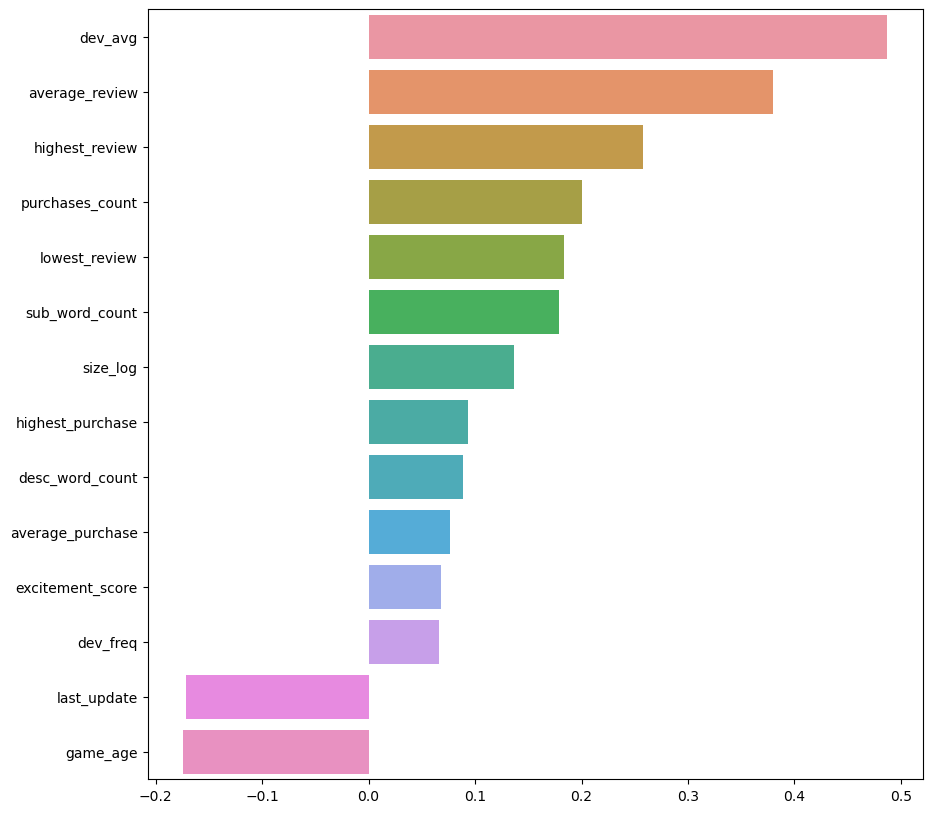

In [277]:
# plot correlation matrix between features and target

corr = df_x.corrwith(df_y)
corr = corr.sort_values(ascending=False)

corr = corr[abs(corr) > 0.06]

plt.figure(figsize=(10, 10))
sns.barplot(x=corr.values, y=corr.index)
plt.show()

In [278]:
# Scale the features
df_x_scaled = scale_data_std(df_x)
df_test_x_scaled = scale_data_std(df_test_x, test=True)

# Select the features
df_x_select = select_features(df_x_scaled, df_y)
df_test_x_select = select_features(df_test_x_scaled, df_test_y, test=True)

In [279]:
# Print the selected features

selector = pickle.load(open('encoders/regression/selector.pkl', 'rb'))
for i in range(len(selector.get_support())): 
    if selector.get_support()[i]:
        print(df_x.columns[i])

game_age
last_update
purchases_count
highest_purchase
average_purchase
sub_word_count
desc_word_count
size_log
dev_avg
lowest_review
highest_review
average_review


In [280]:
# Run the LazyRegressor to get a list of models and their RMSE scores
reg = LazyRegressor(ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(df_x_select, df_test_x_select, df_y, df_test_y)

models = models.sort_values(by='RMSE', ascending=True)
models

100%|██████████| 42/42 [01:18<00:00,  1.87s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.26,0.28,0.57,0.65
NuSVR,0.26,0.28,0.57,0.37
GradientBoostingRegressor,0.25,0.27,0.57,0.74
RandomForestRegressor,0.25,0.27,0.57,2.23
SVR,0.25,0.27,0.57,0.42
LGBMRegressor,0.22,0.24,0.59,0.10
SGDRegressor,0.22,0.24,0.59,0.01
TransformedTargetRegressor,0.22,0.24,0.59,0.02
LinearRegression,0.22,0.24,0.59,0.01


In [281]:
# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(df_x_select, df_y)

# Get the training MSE, R2 score, Testing MSE, and R2 score
mse_train = mean_squared_error(df_y, model.predict(df_x_select))
r2_train = r2_score(df_y, model.predict(df_x_select))
mse_test = mean_squared_error(df_test_y, model.predict(df_test_x_select))
r2_test = r2_score(df_test_y, model.predict(df_test_x_select))

# Print the training MSE and R2 score
print('Training MSE: ', mse_train)
print('Training R2: ', r2_train)

# Print the testing MSE and R2 score
print('Testing MSE: ', mse_test)
print('Testing R2: ', r2_test)

# Display the scores
plot_scores(mse_train, r2_train, mse_test, r2_test)

# Save the model
pickle.dump(model, open('models/regression/lr.pkl', 'wb'))

Training MSE:  0.27957593904031686
Training R2:  0.3463053431039185
Testing MSE:  0.343945817972742
Testing R2:  0.23804417808777223


In [282]:
# Create an elastic net regression model
model = ElasticNet(alpha=0.001)

# Train the model
model.fit(df_x_select, df_y)

# Get the training MSE, R2 score, Testing MSE, and R2 score
mse_train = mean_squared_error(df_y, model.predict(df_x_select))
r2_train = r2_score(df_y, model.predict(df_x_select))
mse_test = mean_squared_error(df_test_y, model.predict(df_test_x_select))
r2_test = r2_score(df_test_y, model.predict(df_test_x_select))

# Print the training MSE and R2 score
print('Training MSE: ', mse_train)
print('Training R2: ', r2_train)

# Print the testing MSE and R2 score
print('Testing MSE: ', mse_test)
print('Testing R2: ', r2_test)

# Display the scores
plot_scores(mse_train, r2_train, mse_test, r2_test)

# Save the model
pickle.dump(model, open('models/regression/elastic_net.pkl', 'wb'))


Training MSE:  0.2795945772094927
Training R2:  0.34626176399032815
Testing MSE:  0.34399105548363756
Testing R2:  0.23794396176591415


In [283]:
# Create a polynomial regression model
model = LinearRegression()

# Generate the polynomial features
poly = PolynomialFeatures(degree=2)
df_x_poly = poly.fit_transform(df_x_select)
df_test_x_poly = poly.transform(df_test_x_select)

# Save the polynomial features
pickle.dump(poly, open('encoders/regression/poly.pkl', 'wb'))

# Train the model
model.fit(df_x_poly, df_y)

# Get the training MSE, R2 score, Testing MSE, and R2 score
mse_train = mean_squared_error(df_y, model.predict(df_x_poly))
r2_train = r2_score(df_y, model.predict(df_x_poly))
mse_test = mean_squared_error(df_test_y, model.predict(df_test_x_poly))
r2_test = r2_score(df_test_y, model.predict(df_test_x_poly))

# Print the training MSE and R2 score
print('Training MSE: ', mse_train)
print('Training R2: ', r2_train)

# Print the testing MSE and R2 score
print('Testing MSE: ', mse_test)
print('Testing R2: ', r2_test)

# Display the scores
plot_scores(mse_train, r2_train, mse_test, r2_test)
# Save the model
pickle.dump(model, open('models/regression/poly_reg.pkl', 'wb'))


Training MSE:  0.2546233558561036
Training R2:  0.40464859810385256
Testing MSE:  0.33845260720447407
Testing R2:  0.2502134899594589


In [284]:
# Create an XGBoost model

import xgboost as xgb

model = xgb.XGBRegressor(subsample= 0.8,
                         reg_lambda= 0.1,
                         reg_alpha= 0.1,
                         n_estimators=500,
                         min_child_weight=1,
                         max_depth= 4,
                         learning_rate= 0.01,
                         gamma =0.1,
                         colsample_bytree= 0.8)

# Train the model
model.fit(df_x_select, df_y)

# Get the training MSE, R2 score, Testing MSE, and R2 score
mse_train = mean_squared_error(df_y, model.predict(df_x_select))
r2_train = r2_score(df_y, model.predict(df_x_select))
mse_test = mean_squared_error(df_test_y, model.predict(df_test_x_select))
r2_test = r2_score(df_test_y, model.predict(df_test_x_select))

# Print the training MSE and R2 score
print('Training MSE: ', mse_train)
print('Training R2: ', r2_train)

# Print the testing MSE and R2 score
print('Testing MSE: ', mse_test)
print('Testing R2: ', r2_test)

# Display the scores
plot_scores(mse_train, r2_train, mse_test, r2_test)

# Save the model
pickle.dump(model, open('models/regression/xgb.pkl', 'wb'))

Training MSE:  0.18766548259106589
Training R2:  0.561207149389513
Testing MSE:  0.32641945477424184
Testing R2:  0.27687097515353487


In [285]:
# Create a Gradient Boosting model

from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(learning_rate=0.01, 
                                  max_depth=5, 
                                  max_features='sqrt', 
                                  min_samples_leaf=1, 
                                  min_samples_split=2, 
                                  n_estimators=500, 
                                  subsample=0.8)

# Train the model
model.fit(df_x_select, df_y)

# Get the training MSE, R2 score, Testing MSE, and R2 score
mse_train = mean_squared_error(df_y, model.predict(df_x_select))
r2_train = r2_score(df_y, model.predict(df_x_select))
mse_test = mean_squared_error(df_test_y, model.predict(df_test_x_select))
r2_test = r2_score(df_test_y, model.predict(df_test_x_select))

# Print the training MSE and R2 score
print('Training MSE: ', mse_train)
print('Training R2: ', r2_train)

# Print the testing MSE and R2 score
print('Testing MSE: ', mse_test)
print('Testing R2: ', r2_test)

# Display the scores
plot_scores(mse_train, r2_train, mse_test, r2_test)

# Save the model
pickle.dump(model, open('models/regression/gb.pkl', 'wb'))

Training MSE:  0.16347915249886083
Training R2:  0.6177587782795777
Testing MSE:  0.3209256119668203
Testing R2:  0.28904168720480694


In [286]:
# Create a Random Forest Regressor model

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=5, 
                              n_estimators=500, 
                              n_jobs=-1)

# Train the model
model.fit(df_x_select, df_y)

# Get the training MSE, R2 score, Testing MSE, and R2 score
mse_train = mean_squared_error(df_y, model.predict(df_x_select))
r2_train = r2_score(df_y, model.predict(df_x_select))
mse_test = mean_squared_error(df_test_y, model.predict(df_test_x_select))
r2_test = r2_score(df_test_y, model.predict(df_test_x_select))

# Print the training MSE and R2 score
print('Training MSE: ', mse_train)
print('Training R2: ', r2_train)

# Print the testing MSE and R2 score
print('Testing MSE: ', mse_test)
print('Testing R2: ', r2_test)

# Display the scores
plot_scores(mse_train, r2_train, mse_test, r2_test)
# Save the model
pickle.dump(model, open('models/regression/rf.pkl', 'wb'))

Training MSE:  0.23277814585335535
Training R2:  0.45572630209579035
Testing MSE:  0.334744088787362
Testing R2:  0.2584291072193008


In [287]:
# Create a CatBoost Regressor model

from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=1000,
                            learning_rate=0.05,
                            depth=3,
                            l2_leaf_reg=1,
                            border_count=32,
                            bagging_temperature=1,
                            fold_permutation_block=1,
                            boosting_type='Plain',
                            random_seed=42,
                            subsample=1.0,
                            colsample_bylevel=0.5,
                            early_stopping_rounds=5,
                            loss_function='RMSE', eval_metric='RMSE',
                          verbose=50)

# Train the model
model.fit(df_x_select, df_y)

# Get the training MSE, R2 score, Testing MSE, and R2 score
mse_train = mean_squared_error(df_y, model.predict(df_x_select))
r2_train = r2_score(df_y, model.predict(df_x_select))
mse_test = mean_squared_error(df_test_y, model.predict(df_test_x_select))
r2_test = r2_score(df_test_y, model.predict(df_test_x_select))

# Print the training MSE and R2 score
print('Training MSE: ', mse_train)
print('Training R2: ', r2_train)

# Print the testing MSE and R2 score
print('Testing MSE: ', mse_test)
print('Testing R2: ', r2_test)

# print catboost weights with the feature names and biases
print(model.get_feature_importance(prettified=True)) 

# Display the scores
plot_scores(mse_train, r2_train, mse_test, r2_test)

# Save the model
pickle.dump(model, open('models/regression/cb.pkl', 'wb'))

0:	learn: 0.6511332	total: 17ms	remaining: 17s
50:	learn: 0.5268074	total: 129ms	remaining: 2.4s
100:	learn: 0.5078571	total: 203ms	remaining: 1.81s
150:	learn: 0.4978150	total: 348ms	remaining: 1.96s
200:	learn: 0.4893412	total: 499ms	remaining: 1.98s
250:	learn: 0.4814771	total: 674ms	remaining: 2.01s
300:	learn: 0.4739127	total: 851ms	remaining: 1.98s
350:	learn: 0.4670272	total: 904ms	remaining: 1.67s
400:	learn: 0.4598434	total: 1.16s	remaining: 1.73s
450:	learn: 0.4541944	total: 1.29s	remaining: 1.57s
500:	learn: 0.4491608	total: 1.45s	remaining: 1.44s
550:	learn: 0.4437140	total: 1.53s	remaining: 1.25s
600:	learn: 0.4387029	total: 1.8s	remaining: 1.19s
650:	learn: 0.4338532	total: 1.92s	remaining: 1.03s
700:	learn: 0.4293456	total: 2.13s	remaining: 908ms
750:	learn: 0.4249201	total: 2.26s	remaining: 751ms
800:	learn: 0.4209634	total: 2.46s	remaining: 612ms
850:	learn: 0.4167086	total: 2.68s	remaining: 469ms
900:	learn: 0.4127527	total: 2.86s	remaining: 314ms
950:	learn: 0.409301

## Hyperparameter Tuning

In [288]:
# Create a SVM Regressor model with Grid Search

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# SVM hyperparameters
svm_params = {
    'C': [0.01, 0.1, 0.8],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['poly', 'rbf'],
    'gamma': ['scale', 'auto'] ,
}

# Define the SVM model
svm_model = SVR()

# Set up grid search with cross-validation
grid_search = GridSearchCV(svm_model, svm_params, cv=5, n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_search.fit(df_x_select, df_y)

# Print the best hyperparameters found by the grid search
print("Best SVM hyperparameters: ", grid_search.best_params_)

# Use the best hyperparameters to train the final model
final_svr_model = SVR(**grid_search.best_params_)
final_svr_model.fit(df_x_select, df_y)

# Get the training MSE, R2 score, Testing MSE, and R2 score
mse_train = mean_squared_error(df_y, final_svr_model.predict(df_x_select))
r2_train = r2_score(df_y, final_svr_model.predict(df_x_select))
mse_test = mean_squared_error(df_test_y, final_svr_model.predict(df_test_x_select))
r2_test = r2_score(df_test_y, final_svr_model.predict(df_test_x_select))

# Print the training MSE and R2 score
print('Training MSE: ', mse_train)
print('Training R2: ', r2_train)

# Print the testing MSE and R2 score
print('Testing MSE: ', mse_test)
print('Testing R2: ', r2_test)

# Save the model
pickle.dump(final_svr_model, open('models/regression/svr.pkl', 'wb'))

# Display the scores
plot_scores(mse_train, r2_train, mse_test, r2_test)


""" 
Best SVM hyperparameters:  {'C': 0.1, 'coef0': 2, 'degree': 4, 'epsilon': 0.08, 'gamma': 'scale', 'kernel': 'poly'}
"""

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best SVM hyperparameters:  {'C': 0.8, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Training MSE:  0.23082629775752522
Training R2:  0.46029004486885117
Testing MSE:  0.33015204553612487
Testing R2:  0.26860202954286905


" \nBest SVM hyperparameters:  {'C': 0.1, 'coef0': 2, 'degree': 4, 'epsilon': 0.08, 'gamma': 'scale', 'kernel': 'poly'}\n"

In [289]:
# Create a Random Forest Regressor with GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

# Define the Random Forest regressor
rf_model = RandomForestRegressor()

# Define the hyperparameter grid for GridSearchCV
params = {
    'max_depth': [4, 5],
    'n_estimators': [500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [42],
    'warm_start': [True],
    'bootstrap': [True],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
    'criterion': ['squared_error'],
    'oob_score': [True]
}

# Define the GridSearchCV object
gs_cv = GridSearchCV(
    estimator=rf_model,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    refit=True,
)

# Fit the GridSearchCV object to the data
gs_cv.fit(df_x_select, df_y)

# Print the best hyperparameters
print(gs_cv.best_params_)

# Use the best hyperparameters to train the final model
final_rf_model = RandomForestRegressor(**gs_cv.best_params_)

final_rf_model.fit(df_x_select, df_y)

# Get the training MSE, R2 score, Testing MSE, and R2 score
mse_train = mean_squared_error(df_y, final_rf_model.predict(df_x_select))
r2_train = r2_score(df_y, final_rf_model.predict(df_x_select))
mse_test = mean_squared_error(df_test_y, final_rf_model.predict(df_test_x_select))
r2_test = r2_score(df_test_y, final_rf_model.predict(df_test_x_select))

# Save the model
pickle.dump(final_rf_model, open('models/regression/rf_hyper.pkl', 'wb'))

# Print the training MSE and R2 score
print('Training MSE: ', mse_train)
print('Training R2: ', r2_train)

# Print the testing MSE and R2 score
print('Testing MSE: ', mse_test)
print('Testing R2: ', r2_test)

# Display the scores
plot_scores(mse_train, r2_train, mse_test, r2_test)

{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'oob_score': True, 'random_state': 42, 'warm_start': True}
Training MSE:  0.23300678116466986
Training R2:  0.4551917150283299
Testing MSE:  0.3345109774077841
Testing R2:  0.25894552743301424
